In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib notebook

# This Laptop Is Inadequate:
# An Aperitif for DSFP Session 8

**Version 0.1**

By AA Miller 2019 Mar 24

When I think about LSST there are a few numbers that always stick in my head: 

  -  37 billion (the total number of sources that will be detected by LSST)
  -  10 (the number of years for the baseline survey)
  -  1000 (~the number of observations per source)
  -  37 trillion ($37 \times 10^9 \times 10^4$ = the total number of source observations)

These numbers are *eye-popping*, though the truth is that there are now several astronomical databases that have $\sim{10^9}$ sources (e.g., PanSTARRS-1, which we will hear more about later today). 

A pressing question, for current and future surveys, is: how are we going to deal with all that data?

If you're anything like me - then, you love your laptop. 

And if you had it your way, you wouldn't need anything but your laptop... ever.

But is that practical?

## Problem 1) The Inadequacy of Laptops

**Problem 1a**

Suppose you could describe every source detected by LSST with a single number. Assuming you are on a computer with a 64 bit architecture, to within an order of magnitude, how much RAM would you need to store every LSST source within your laptop's memory?

*Bonus question* - can you think of a single number to describe every source in LSST that could produce a meaningful science result?

*Take a minute to discuss with your partner*

**Solution 1a**


As for a single number to perform useful science, I can think of two. 

First - you could generate a [heirarchical triangular mesh](http://www.skyserver.org/HTM/) with enough trixels to characterize every LSST resolution element on the night sky. Then you could assign a number to each trixel, and describe the position of every source in LSST with a single number. Under the assumption that every source detected by LSST is a galaxy, this is not a terrible assumption, you could look at the clustering of these positions to (potentially) learn things about structure formation or galaxy formation (though without redshifts you may not learn all that much).

The other number is the flux (or magnitude) of every source in a single filter. Again, under the assumption that everything is a galaxy, the number counts (i.e. a histogram) of the flux measurements tells you a bit about the Universe. 

It probably isn't a shock that you won't be able to analyze every individual LSST source on your laptop.

But that raises the question - how should you analyze LSST data?

  -  By buying a large desktop?
  -  On a local or national supercomputer?
  -  In the cloud?
  -  On computers that LSST hosts/maintains?

But that raises the question - how should you analyze LSST data?

  -  By buying a large desktop? (impractical to ask of everyone working on LSST)
  -  On a local supercomputer? (not a bad idea, but not necessarily equitable)
  -  In the cloud? (AWS is expensive)
  -  On computers that LSST hosts/maintains? (probably the most fair, but this also has challenges)

We will discuss some of these issues a bit later in the week...

## Problem 2) Laptop or Not You Should Be Worried About the Data

### Pop quiz

We will now re-visit a question from a previous session:

**Problem 2a**

What is data?

*Take a minute to discuss with your partner*

**Our Answer:** Information about something (that we measure)

**Solution 2a**



Constants

This leads to another question: 

Q - What is the defining property of a constant?

A - They don't change.

If data are constants, and constants don't change, then we should probably be sure that our data storage solutions do not alter the data in any way. 

Within the data science community, the python [`pandas`](https://pandas.pydata.org/) package is particularly popular for reading, writing, and manipulating data (we will talk more about the utility of `pandas` later). 

The `pandas` docs state the `read_csv()` method is the [workhorse function for reading text files](http://pandas.pydata.org/pandas-docs/stable/user_guide/io.html#csv-text-files). Let's now take a look at how well this workhorse "maintains the constant nature of data". 

**Problem 2b**

Create a `numpy` array, called `nums`, of length 10000 filled with random numbers. Create a `pandas` `Series` object, called `s`, based on that array, and then write the `Series` to a file called `tmp.txt` using the `to_csv()` method.

*Hint* - you'll need to name the `Series` and add the `header=True` option to the `to_csv()` call.

In [8]:
nums = np.random.random(10000)
s = pd.Series(nums, name = 'nums')

s.to_csv('tmp.txt', header=True, index=False)

**Problem 2c**

Using the `pandas` `read_csv()` method, read in the data to a new variable, called `s_read`. Do you expect `s_read` and `nums` to be the same? Check whether or not your expectations are correct. 

*Hint* - take the sum of the difference not equal to zero to identify if any elements are not the same.

In [14]:
s_read = pd.read_csv('tmp.txt')

np.all(s_read.nums.values == nums)

False

In [19]:
np.sum(s_read.nums - nums != 0)

2242

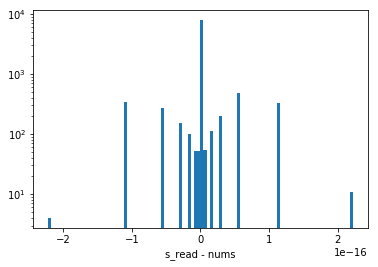

In [20]:
plt.hist(s_read.nums - nums, 100)
plt.xlabel('s_read - nums')
plt.yscale('log')

So, it turns out that $\sim{23}\%$ of the time, `pandas` does not in fact read in the same number that it wrote to disk.

The truth is that these differences are quite small (see next slide), but there are many mathematical operations (e.g., subtraction of very similar numbers) that may lead these tiny differences to compound over time such that your data are not, in fact, constant.

In [21]:
print(np.max(np.abs(nums - s_read['nums'].values)))

2.220446049250313e-16


So, what is going on?

Sometimes, when you convert a number to ASCII (i.e. text) format, there is some precision that is lost in that conversion. 

How do you avoid this?

**One way is to directly write your files in binary.** To do so has serveral advantages: it is possible to reproduce byte level **accuracy**, and, binary storage is almost always more **efficient than text storage** (the same number can be written in binary with less space than in ascii). 

The downside is that developing your own procedure to write data in binary is a pain, and it places strong constraints on where and how you can interact with the data once it has been written to disk. 

Fortuantely, we live in a world with `pandas`. All this hard work has been done for you, as `pandas` naturally interfaces with the [`hdf5`](https://www.hdfgroup.org/solutions/hdf5/) binary table format. (You may want to also take a look at [`pyTables`](https://www.pytables.org/))

(Historically astronomers have used [FITS](https://fits.gsfc.nasa.gov/fits_primer.html) files as a binary storage solution) 

**Problem 2d**

Repeat your procedure from above, but instead of writing to a csv file, use the `pandas` `to_hdf()` and `read_df()` method to see if there are any differences in `s` and `s_read`.  

*Hint* - You will need to specify a name for the table that you have written to the `hdf5` file in the call to `to_hdf()` as a required argument. Any string will do.

*Hint 2* - Use `s_read.values` instead of `s_read['nums'].values`.

In [26]:
s.to_hdf('tmp.h5', 'nums') # complete
s_read = pd.read_hdf('tmp.h5')# complete

np.all(s_read.values == nums)

True

/home/daniela/anaconda3/envs/DSFP/lib/python3.6/site-packages/matplotlib/axes/_base.py:3364: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=10000.0, top=10000.0
  self.set_ylim(upper, lower, auto=None)


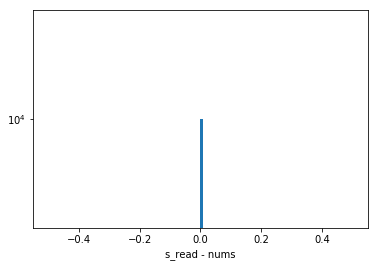

In [28]:
plt.hist(s_read.values - nums, 100)
plt.xlabel('s_read - nums')
plt.yscale('log')

So, if you are using `pandas` anyway, and if you aren't using `pandas` –– check it out!, then I strongly suggest removing csv files from your workflow to instead focus on binary hdf5 files. This requires typing the same number of characters, but it ensures byte level reproducibility.  

And reproducibiliy is the pillar upon which the scientific method is built. 

Is that the end of the story? ... No.

In the previous example, I was being a little tricky in order to make a point. It *is* in fact possible to create reproducible csv files with `pandas`. By default, `pandas` sacrifices a little bit of precision in order to gain a lot more speed. If you want to ensure reproducibility then you can specify that the `float_precision` should be `round_trip`, meaning you get the same thing back after reading from a file that you wrote to disk. 

In [30]:
s.to_csv('tmp.txt', header=True, index=False)

s_read = pd.read_csv('tmp.txt', float_precision='round_trip')

sum(nums - s_read['nums'].values != 0)

0

So was all of this in service of a lie?

No. What I said before remains true - text files do not guarantee byte level precision, and they take more space on disk. Text files have some advantages:

  -  anyone, anywhere, on any platform can easily manipulate text files
  -  text files can be easily inspected (and corrected) if necessary
  -  special packages are needed to read/write in binary
  -  binary files, which are not easily interpretable, are difficult to use in version control (and banned by some version control platforms)

To summarize, here is my advice: think of binary as your (new?) default for storing data.

But, as with all things, consider your audience: if you are sharing/working with people that won't be able to deal with binary data, or, you have an incredibly small amount of data, csv (or other text files) should be fine.

## Problem 3) Binary or ASCII - Doesn't Matter if You Aren't Organized

While the reproducibility of data is essential, ultimately, concerns about binary vs ascii are useless if you cannot access the data you need *when* you need it.

Your data are valuable (though cheaper to acquire than ever before), which means you need a good solution for managing that data, or else you are going to run into a significant loss of time and money.

**Problem 3a**

How would you organize the following: (a) 3 very deep images of a galaxy, (b) 4 nights of optical observations ($\sim$50 images night$^{-1}$) of a galaxy cluster in the $ugrizY$ filters, (c) images from a 50 night time-domain survey ($\sim$250 images night$^{-1}$) covering 1000 deg$^2$?

Similarly, how would you organize: (a) photometric information for your galaxy observations, (b) photometry for all the galaxies in your cluster field, (c) the observations/light curves from your survey?

*Take a minute to discuss with your partner*

**My Solution 3a**

paper on data structure: 1703.04695  (tree structure)

Keeping in mind that there are several suitable answers to each of these questions, here are a few thoughts: (a) the 3 images should be kept together, probably in a single file directory. (b) With 200 images taken over the course of 4 nights, I would create a directory structure that includes every night (top level), with sub-directories based on the individual filters. (c) Similar to (b), I'd create a tree-based file structure, though given that the primary science is time variability, I would likely organize the observations by fieldID at the top level, then by filter and date after that. 

As a final note - for each of these data sets, backups are essential! There should be no risk of a single point failure wiping away all that information for good.

The photometric data requires more than just a file structure. In all three cases I would want to store everything in a single file (so directories are not necessary). 

For 3 observations of a single galaxy, I would use... a text file (not worth the trouble for binary storage)

Assuming there are 5000 galaxies in the cluster field, I would store the photometric information that I extract for those galaxies in a *table*. In this table, each row would represent a single galaxy, while the columns would include brightness/shape measurements for the galaxies in each of the observed filters. I would organize this table as a `pandas` DataFrame (and write it to an hdf5 file). 

For the time-domain survey, the organization of all the photometric information is far less straight forward.

Could you use a single table? Yes. Though this would be highly inefficient given that not all sources were observed at the same time. The table would then need columns like `obs1_JD`, `obs1_flux`, `obs1_flux_unc`, `obs2_JD`, `obs2_flux`, `obs2_flux_unc`, ..., all the way up to $N$, the maximum number of observations of any individual source. This will lead to several columns that are empty for several sources. 

I would instead use a collection of tables. First, a master source table:

|objID|RA|Dec|mean_mag|mean_mag_unc|
|:--:|:--:|:--:|:--:|:--:|
|0001|246.98756|-12.06547|18.35|0.08|
|0002|246.98853|-12.04325|19.98|0.21|
|.|.|.|.|.|
|.|.|.|.|.|
|.|.|.|.|.|

Coupled with a table holding the individual flux measurements:

|objID|JD|filt|mag|mag_unc|
|:--:|:--:|:--:|:--:|:--:|
|0001|2456785.23465|r|18.21|0.07|
|0001|2456785.23469|z|17.81|0.12|
|.|.|.|.|.|
|.|.|.|.|.|
|.|.|.|.|.|
|0547|2456821.36900|g|16.04|0.02|
|0547|2456821.36906|i|17.12|0.05|
|.|.|.|.|.|
|.|.|.|.|.|
|.|.|.|.|.|

The critical thing to notice about these tables is that they both contain `objID`. That information allows us to connect the tables via a "join". This table, or relational, structure allows us to easily connect subsets of the data as way to minimize storage (relative to having everything in a single table) while also maintaining computational speed.

Typically, when astronomers (or data scientists) need to organize data into several connected tables capable of performing fast relational algebra operations they use a database. We will hear a lot more about databases over the next few days, so I won't provide a detailed introduction now. 

One very nice property of (many) database systems is that provide an efficient means for searching large volumes of data that cannot be stored in memory (recall problem **1a**). Whereas, your laptop, or even a specialized high-memory computer, would not be able to open a csv file with all the LSST observations in it. 

Another quick aside –– `pandas` can deal with files that are too large to fit in memory by loading a portion of the file at a time:

    light_curves = pd.read_csv(lc_csv_file, chunksize=100000)

If you are building a data structure where loading the data in "chunks" is necessary, I would strongly advise considering an alternative to storing the data in a csv file. 

A question you may currently be wondering is: why has there been such an intense focus on `pandas` today?

The short answer: the developers of `pandas` wanted to create a product that is good at relational algebra (like traditional database tools) but with lower overhead in construction, and a lot more flexibility (which is essential in a world of heterogeneous data storage and management, see Tuesday's lecture on Data Wrangling). 

(You'll get several chances to practice working with databases throughout the week)

We will now run through a few examples that highlight how `pandas` can be used in a manner similar to a relational database. Throughout the week, as you think about your own data management needs, I think the critical thing to consider is scope. Can my data be organized into something that is smaller than a full-on database?

**Problem 3b**

Download the [SDSS data set](https://northwestern.box.com/s/sjegm0tx62l2i8dkzqw22s4gmq1a9sg1) that will be used in the exercises for tomorrow. 

Read that data, stored in a csv file, into a `pandas` DataFrame called `sdss_spec`.

In a lecture where I have spent a great deal of time describing the value of binary data storage, does the fact that I am now providing a (moderate) amount of data as a plain ascii file mean that I am a bad teacher...

*probably*

In [31]:
sdss_spec = pd.read_csv("DSFP_SDSS_spec_train.csv")
sdss_spec.head()

,specObjID,z,type,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,modelMag_u,modelMag_g,...,extinction_i,extinction_z,w1mpro,w1snr,w2mpro,w2snr,w3mpro,w3snr,w4mpro,w4snr
0,299567742770505728,0.071414,ext,20.88291,19.23907,18.56170,18.09715,17.76469,19.62189,18.03702,...,0.061267,0.045572,14.395,21.1,14.236,15.6,11.029,6.8,8.579,-0.9
1,299568017178650624,0.071380,ext,20.88291,19.23907,18.56170,18.09715,17.76469,19.62189,18.03702,...,0.061267,0.045572,14.395,21.1,14.236,15.6,11.029,6.8,8.579,-0.9
2,299566643258877952,0.088173,ext,20.84844,18.96040,18.08027,17.62953,17.31857,20.18508,18.26120,...,0.047582,0.035392,14.162,35.0,13.970,22.3,12.233,2.9,9.067,-0.3
3,299569116690278400,0.088161,ext,20.84844,18.96040,18.08027,17.62953,17.31857,20.18508,18.26120,...,0.047582,0.035392,14.162,35.0,13.970,22.3,12.233,2.9,9.067,-0.3
4,299568292056557568,0.066539,ext,21.28256,19.61427,18.98529,18.52956,18.26322,20.18081,18.47435,...,0.058709,0.043669,14.734,30.6,14.512,17.6,11.078,9.8,9.054,2.3


`pandas` provides many different methods for selecting columns from the DataFrame. Supposing you wanted `psfMag`, you could use any of the following:

    sdss_spec['psfMag_g']
    sdss_spec[['psfMag_r', 'psfMag_z']]
    sdss_spec.psfMag_g

(notice that selecting multiple columns requires a list within `[]`)

**Problem 3c**

Plot a histogram of the `psfMag_g` - `modelMag_g` distribution for the data set (which requires a selection of those two columns).

Do you notice anything interesting?

*Hint* - you may want to use more than the default number of bins (=10).

Text(0.5, 0, 'psf - model')

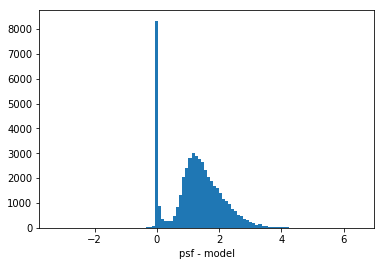

In [34]:
mag_diff = sdss_spec.psfMag_g - sdss_spec.modelMag_g

plt.hist(mag_diff, bins = 100)
plt.xlabel('psf - model')

Pandas can also be used to aggregate the results of a search.

**Problem 3d**

How many extended sources (`type` = `ext`) have `modelMag_i` between 19 and 20? Use as few lines as possible.

In [37]:
# complete

len(sdss_spec[(sdss_spec.type == 'ext') & 
             (sdss_spec.modelMag_i >= 19) &
             (sdss_spec.modelMag_i <= 20)])

369

`pandas` also enables [`GROUP BY`](http://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html) operations, where the data are split based on some criterion, a function is then applied to the groups, and the results are then combined back into a data structure.

**Problem 3e**

Group the data by their `type` and then report the minimum, median, and maximum redshift of each group. Can you immediately tell anything about these sources based on these results?

*Hint* - just execute the cell below.

In [38]:
grouped = sdss_spec.groupby([sdss_spec.type])
print(grouped['z'].min())
print(grouped['z'].median())
print(grouped['z'].max())

type
ext   -0.005469
ps    -0.010875
Name: z, dtype: float64
type
ext    0.107352
ps     0.000275
Name: z, dtype: float64
type
ext    6.839257
ps     6.687022
Name: z, dtype: float64


Finally, we have only briefly discussed joining tables, but this is where relational databases really shine.

For this example we only have a single table, so we will exclude any examples of a `pandas` join, but there is functionality to [join or merge](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) dataframes in a fashion that is fully analogous to databases.

In summary, there are many different possible solutions for data storage and management. 

For "medium" to "big" data that won't easily fit into memory ($\sim$16 GB), it is likely that a database is your best solution. For slightly smaller problems `pandas` provides a really nice, lightweight alternative to a full blown database that nevertheless maintains a lot of the same functionality and power.

## Problem 4) We Aren't Done Talking About Your Laptop's Inadequacies

So far we have been focused on only a single aspect of computing: storage (and your laptop sucks at that). 

But here's the thing - your laptop is also incredibly slow.

Supposing for a moment that you could hold all (or even a significant fraction) of the information from LSST in memory on your laptop, you would still be out of luck, as you would die before you could actually process the data and make any meaningful calculations.

(we argued that it would take [$\sim$200 yr to process LSST on your laptop](https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/blob/master/Session5/Day1/PhotonsArentScienceSolutions.ipynb) in Session 5)

You are in luck, however, as you need not limit yourself to your laptop. You can take advantage of multiple computers, also known  as parallel processing.

At a previous session, I asked Robert Lupton, one of the primary developers of the LSST photometric pipeline, "How many CPUs are being used to process LSST data?" To which he replied, "However many are needed to process everything within 1 month."

The critical point here is that if you can figure out how to split a calculation over multiple computers, then you can finish any calculation arbitrarily fast with enough processors (to within some limits, like the speed of light, etc)

We will spend a lot more time talking about both efficient algorithm design and parallel processing later this week, but I want to close with a quick example that touches on each of these things.

Suppose that you have some 2k x 2k detector (i.e. 4 million pixels), and you need to manipulate the data in that array. For instance, the detector will report the number of counts per pixel, but this number is larger than the actual number of detected photons by a factor $g$, the gain of the telescope.

How long does it take divide every pixel by the gain?

(This is where I spend a moment telling you that - if you are going to time portions of your code as a means of measuring performance it is essential that you turn off *everything else* that may be running on your computer, as background processes can mess up your timing results)

In [39]:
import time

pixel_data = np.random.rand(4000000)
photons = np.empty_like(pixel_data)

tstart = time.time()
for pix_num, pixel in enumerate(pixel_data):
    photons[pix_num] = pixel/8
trun = time.time() - tstart
print('It takes {:.6f} s to correct for the gain'.format(trun))

It takes 1.863583 s to correct for the gain


1.5 s isn't too bad in the grand scheme of things. 

Except that this example should make you cringe. There is absolutely no need to use a for loop for these operations.

This brings us to fast coding lesson number 1 - **vectorize everything**.

In [40]:
photons = np.empty_like(pixel_data)

tstart = time.time()
photons = pixel_data/8
trun = time.time() - tstart
print('It takes {:.6f} s to correct for the gain'.format(trun))

It takes 0.019053 s to correct for the gain


By removing the for loop we improve the speed of this particular calculation by a factor of $\sim$125. That is a massive win.

Alternatively, we could have sped up the operations via the use of parallel programing. The [`multiprocessing`](https://docs.python.org/2/library/multiprocessing.html) library in python makes it relatively easy to implement parallel operations. There are many different ways to implement parallel processing in python, here we will just use one simple example.

(again, we will go over multiprocessing in far more detail later this week)

In [41]:
from multiprocessing import Pool

def divide_by_gain(number, gain=8):
    return number/gain

pool = Pool()

tstart = time.time()
photons = pool.map(divide_by_gain, pixel_data)
trun = time.time() - tstart
print('It takes {:.6f} s to correct for the gain'.format(trun))

It takes 21.425748 s to correct for the gain


Wait, parallel processing slows this down by a factor $\sim$7? What's going on here? 

It turns out there is some overhead in copying the data and spawning multiple processes, and in this case that overhead is enormous. Of course, for more complex functions/operations (here we were only doing simple division), that overhead is tiny compared to the individual calculations and using multiple processors can lead to almost an $N$x gain in speed, where $N$ is the number of processors available.

This brings me to fast coding lesson number 2 - **before you parallelize, profile**. (We will talk more about software profiling later in the week), but in short - there is no point to parallelizing inefficient operations. Even if the parallel gain calculation provided a factor of $\sim$4 (the number of CPUS on my machine) speed up relative to our initial for loop, that factor of 4 is a waste compared to the factor of 125 gained by vectorizing the code.

## Conclusions

As we go through this week - think about the types of problems that you encounter in your own workflow, and consider how you might be able to improve that workflow by moving off of your laptop.

This may come in several forms, including: superior data organization, better data structures (`pandas` or databases), more efficient algorithms, and finally parallel processing.